**The flow of the Notebook:**

1. Description of the Problem Statement.

2. Covid-19 Dataset Loading.

3. Check The Dataset.

4. Data Preprocessing.

5. Build a Simple LSTM Model.

6. Train The Model.

7. Prediction

**Problem Statement:**

Analyzing a global COVID-19 time series dataset to gain insights into the spread of the virus and develop a predictive model to forecast COVID-19 cases for a specific country using Long Short-Term Memory (LSTM) neural networks. The goal is to provide accurate predictions of future COVID-19 cases for informed decision-making and resource allocation.

**Import Libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import pandas as pd
import math
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, Bidirectional, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

**Choose a specific country for prediction Covid-19 cases of this country**

In [5]:
country = "Japan"

**Load The Dataset and analsis COVID-19 confirmed cases**

Total days in the dataset 1143


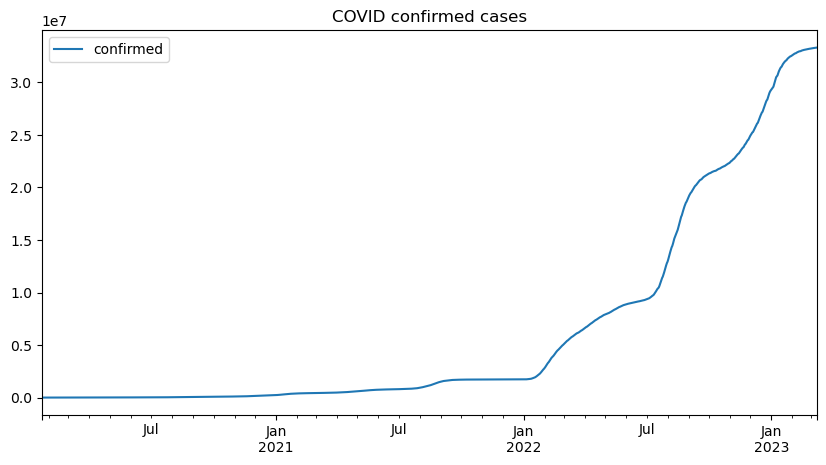

In [6]:
# Total COVID confirmed cases
df_confirmed = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(), columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index, format='%m/%d/%y')

df_confirmed_country.plot(figsize=(10, 5), title="COVID confirmed cases")

df_confirmed_country.tail(10)

print("Total days in the dataset", len(df_confirmed_country))

**Data Preprocessing**

In [7]:
# Use data until 14 days before as training
x = len(df_confirmed_country) - 14

train = df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

In [8]:
# scale or normalize data as the data is too skewed
scaler = MinMaxScaler()
scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [9]:
# Use TimeseriesGenerator to generate data in sequences
seq_size = 7  # number of steps (lookback)
n_features = 1  # number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train))  # 271
print("Total number of samples in the generated data = ", len(train_generator))  # 264 with seq_size=7

Total number of samples in the original training data =  1129
Total number of samples in the generated data =  1122


In [10]:
# Check data shape from generator
x, y = train_generator[10]  # Check train_generator
# Takes 7 days as x and 8th day as y (for seq_size=7)

In [11]:
# Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test))  # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator))  # 7
# Check data shape from generator
x, y = test_generator[0]

Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


**Build a Simple LSTM Model**

In [12]:
# Define Model
input_layer = Input(shape=(seq_size, n_features))
lstm1 = LSTM(150, activation='relu', return_sequences=True)(input_layer)
lstm2 = LSTM(64, activation='relu')(lstm1)
dense1 = Dense(64)(lstm2)
output_layer = Dense(1)(dense1)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 7, 150)            91200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...


**Train The Model**

In [13]:
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)

Epoch 1/50


C:\Users\sazid\AppData\Local\Temp\ipykernel_28840\1350031766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


10/10 [==============================] - 5s 122ms/step - loss: 0.1135 - val_loss: 0.6460
Epoch 2/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0710 - val_loss: 0.2960
Epoch 3/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0293 - val_loss: 0.1320
Epoch 4/50
10/10 [==============================] - 0s 19ms/step - loss: 0.0088 - val_loss: 0.0335
Epoch 5/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0436 - val_loss: 0.1773
Epoch 6/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0125 - val_loss: 0.1262
Epoch 7/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0270 - val_loss: 0.0711
Epoch 8/50
10/10 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.0406
Epoch 9/50
10/10 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0218
Epoch 10/50
10/10 [==============================] - 0s 50ms/step - loss: 0.0063 - val_loss: 0.0090
Epoch 11/50
10/10 [

**Training and Validation Loss Checking** 

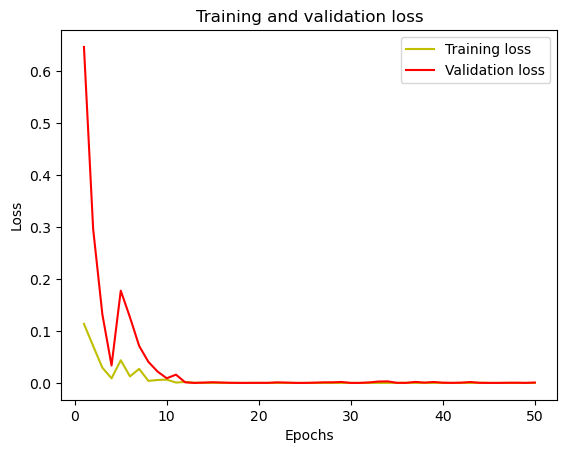

In [14]:
# plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Prediction** 

In [15]:
# forecast
prediction = []  # Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:]  # Final data points in train
current_batch = current_batch.reshape(1, seq_size, n_features)  # Reshape

In [16]:
# Predict future, beyond test dates
future = 7  # Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 [==============================] - 0s 40ms/step


In [17]:
# Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  # Get dates for test data

In [18]:
# Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [19]:
# Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed", "predicted"], index=time_series_array)

df_forecast.loc[:, "predicted"] = rescaled_prediction[:, 0]
df_forecast.loc[:, "actual_confirmed"] = test["confirmed"]

<Axes: title={'center': 'Predictions for next 7 days'}>

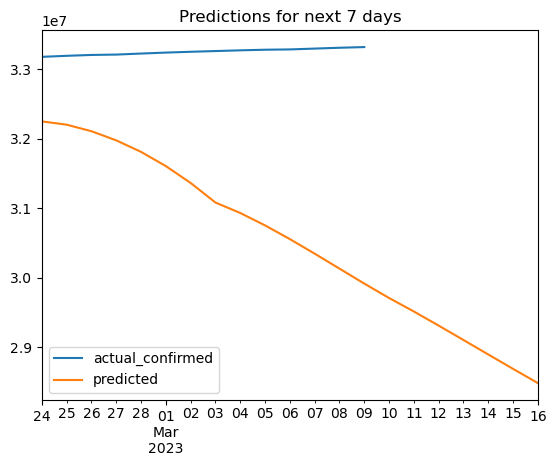

In [20]:
# Plot
df_forecast.plot(title="Predictions for next 7 days")